**Imports**

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd
import sys

sys.path.append('C:\\Coding\\customer-churn-prediction\\src')
from utils import download_telco_churn_dataset, split_test_train
from preprocessing import get_preproc

RND_SEED = 42

**Getting Preprocessing and Data**

In [42]:
telco = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
X_train, X_test, y_train, y_test = split_test_train(telco)

preprocessing = get_preproc()

# Models

**Help Function**

Функция для оценки различных моделей на тестовой и тернировочных данных.

In [43]:
from sklearn.utils import class_weight

def fit_and_evaluate(models, cv=10):
    # Крафтим пайплайны для каждой модели
    pipelines = {}

    for name, model in models:
        pipelines[name] = (ImbPipeline([
            ("preproc", preprocessing.named_steps['preproc']),
            ("smote", preprocessing.named_steps['smote']),
            ("model", model)
        ]))

    metrics = {}

    # Оценивать модели будем по roc_auc score
    for name, model in pipelines.items():
        # Оценим сырые модельки на CV
        roc_auc_cv = cross_val_score(
            model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1).mean()

        model.fit(X_train, y_train)

        y_pred_test = model.predict(X_test)

        # Metrics evaluating
        roc_auc_test = roc_auc_score(y_test, y_pred_test)

        metrics[name] = {
            'roc_auc_test': roc_auc_test,
            'roc_auc_cv': roc_auc_cv,
        }

    sorted_metrics = dict(
        sorted(metrics.items(), key=lambda item: -item[1]['roc_auc_cv']))

    print(f"ТОП МОДЕЛЕЙ по ROC-AUC:")
    for name, metric in sorted_metrics.items():
        print(
            "\n" + f"{name} : \nAUC: {metric['roc_auc_cv']}")

## Models Comparation

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=RND_SEED, verbose=-1)

lr = LogisticRegression(random_state=RND_SEED, penalty='l2')

lin_svc = LinearSVC(C=1, random_state=RND_SEED)

gb = GradientBoostingClassifier(random_state=RND_SEED)

svc = SVC(C=1, random_state=RND_SEED)

rnd_forest = RandomForestClassifier(random_state=RND_SEED, n_jobs=-1)

xgb = XGBClassifier(random_state=RND_SEED, n_jobs=-1)

models = [
    ("Logistic Regression L2", lr),
    ("LightGBM", lgbm),
    ("RND Forest", rnd_forest),
    ("XGB Classifier", xgb),
    ("Gradient Boosting", gb),
    ("Linear SVC", lin_svc),
    ("SVC", svc),
]

In [46]:
fit_and_evaluate(models)

# Linear SVC : 
# AUC: 0.8443721857033395

# Logistic Regression L2 : 
# AUC: 0.8433375626729104

# Gradient Boosting : 
# AUC: 0.83925947931984

ТОП МОДЕЛЕЙ по ROC-AUC:

Gradient Boosting : 
AUC: 0.8414493055602985

Logistic Regression L2 : 
AUC: 0.8373337846544386

Linear SVC : 
AUC: 0.8315463078822196

LightGBM : 
AUC: 0.828942697750384

RND Forest : 
AUC: 0.8222686919671831

SVC : 
AUC: 0.8216736611624962

XGB Classifier : 
AUC: 0.8166553502747138


Непосредственно в этой задаче мне важен `Recall` на положительном класса, то есть процент верно определенных `Churn`.

## Lin SVC + GB + Logist Regr

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform, randint


def fine_tuning_models(models_data):
    for name, model_data in models_data.items():
        models_data[name] = {
            "pipeline": ImbPipeline([
                ("preproc", preprocessing.named_steps['preproc']),
                ("smote", preprocessing.named_steps['smote']),
                ("model", model_data["model"]),
            ]),
            "param_distrib": model_data["param_disturb"],
        }

        roc_auc_losses = cross_val_score(
            models_data[name]["pipeline"], X_train, y_train, cv=10, n_jobs=-1, scoring='roc_auc')
        print(f'{name} ROC-AUC:\n{pd.Series(roc_auc_losses).mean()}')

    print('=' * 50 + "Tuned models!!!" + '=' * 50)

    best_models = {}

    for name, model_data in models_data.items():
        rnd_search = RandomizedSearchCV(model_data["pipeline"], param_distributions=model_data["param_distrib"],
                                        n_iter=50, cv=5, n_jobs=-1, random_state=RND_SEED, scoring='roc_auc')
        rnd_search.fit(X_train, y_train)

        roc_auc_losses_cv = rnd_search.best_score_

        print(f'{name} AUC:\n{pd.Series(roc_auc_losses_cv).mean()}')

        best_models[name] = rnd_search.best_estimator_

    return best_models
        
    

In [ ]:
pd_lin_svc = {
    "model__tol": uniform(1e-6, 1e-4),
    "model__C": loguniform(0.01, 5),
    "model__fit_intercept": [False],
}

pd_gb = {
    "model__learning_rate": loguniform(0.05, 0.1),
    "model__n_estimators": randint(100, 200),
    "model__max_depth": randint(3, 5),
    "model__max_features": ['sqrt', 'log2', None],
}

pd_lr = [
    {
        "model__penalty": ['l2'],
        "model__tol": uniform(1e-6, 1e-4),
        "model__C": loguniform(0.01, 2),
        "model__max_iter": randint(50, 500),
        "model__solver": ['lbfgs', 'liblinear'],
    }
]

models_data = {
    "Logistic Regression": {
        "model": lr,
        "param_disturb": pd_lr,
    },
    "Gradient Boosting": {
        "model": gb,
        "param_disturb": pd_gb,
    },
    "Linear SVC": {
        "model": lin_svc,
        "param_disturb": pd_lin_svc,
    },
}

In [ ]:
best_models = fine_tuning_models(models_data)

Logistic Regression ROC-AUC:
0.8373337846544386
Gradient Boosting ROC-AUC:
0.8414493055602985
Linear SVC ROC-AUC:
0.8315463078822196
==================================================Tuned models!!!==================================================
Logistic Regression AUC:
0.8411944300018808
Gradient Boosting AUC:
0.843016852952782
Linear SVC AUC:
0.8392486977418278


Тут лучше всего себя показала логистическая регрессия!

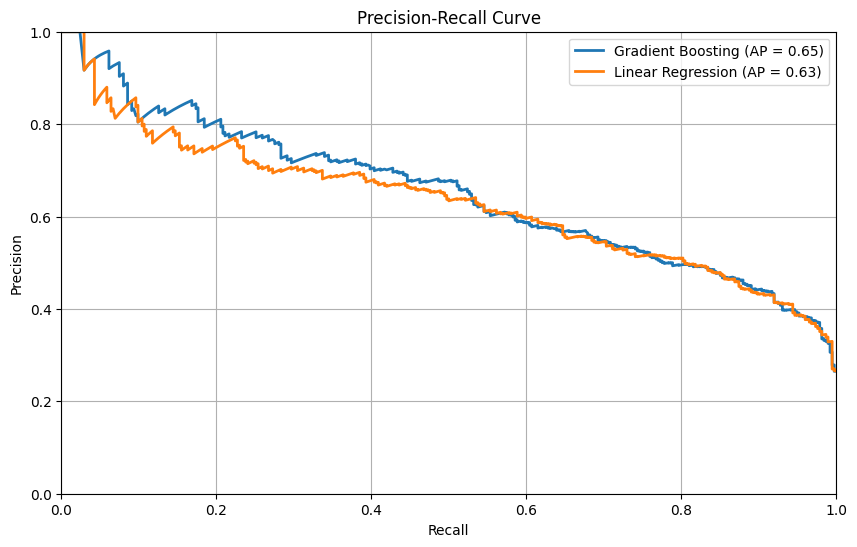

In [ ]:
gb_tuned = best_models["Gradient Boosting"]
lr_tuned = best_models["Logistic Regression"]
lin_svc_tuned = best_models["Linear SVC"]

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

y_scores = gb_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'Gradient Boosting (AP = {average_precision:.2f})')

y_scores = lr_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, linewidth=2, label=f'Linear Regression (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve, cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred_cv = cross_val_predict(lr_tuned, X_train, y_train, cv=10, n_jobs=-1)
cm_cv = confusion_matrix(y_train, y_pred_cv)

cm_cv

array([[3145,  994],
       [ 350, 1145]])

In [ ]:
from sklearn.metrics import precision_recall_curve

def f1(precision_, recall_):
    if precision_ + recall_ == 0:
        return 0.0
    
    return 2 * (precision_ * recall_) / (precision_ + recall_)

y_pred_proba = gb_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

f1s = []
max_f1_score = 0
max_f1_idx = 0

for i in range(len(thresholds)):
    f1s.append(f1(precision[i], recall[i]))
    if max_f1_score < f1s[i]:
        max_f1_score = f1s[i]
        max_f1_idx = i

optimal_idx = np.argmin(recall >= 0.9)
optimal_threshold_recall = thresholds[optimal_idx]
optimal_threshold_f1 = thresholds[max_f1_idx]

y_pred_otimised_recall = (y_pred_proba >= optimal_threshold_recall).astype(int)
y_pred_otimised_f1 = (y_pred_proba >= optimal_threshold_f1).astype(int)

In [47]:
print(f'THRESHOLD: {optimal_threshold_recall}')
print(f'F1: {f1_score(y_test, y_pred_otimised_recall)}')
print(f'P: {precision_score(y_test, y_pred_otimised_recall)}')
print(f'R: {recall_score(y_test, y_pred_otimised_recall)}')
print()
print(f'THRESHOLD: {optimal_threshold_f1}')
print(f'F1: {f1_score(y_test, y_pred_otimised_f1)}')
print(f'P: {precision_score(y_test, y_pred_otimised_f1)}')
print(f'R: {recall_score(y_test, y_pred_otimised_f1)}')

THRESHOLD: 0.2848511876151083
F1: 0.5920704845814978
P: 0.44152431011826543
R: 0.8983957219251337

THRESHOLD: 0.5186069867298502
F1: 0.620380739081747
P: 0.5337186897880539
R: 0.7406417112299465


In [ ]:
from sklearn.model_selection import FixedThresholdClassifier
 
lr_tuned = FixedThresholdClassifier(lr_tuned, threshold=optimal_threshold_f1)

y_pred_cv = cross_val_predict(lr_tuned, X_train, y_train, cv=10, n_jobs=-1)
cm_cv = confusion_matrix(y_train, y_pred_cv)

cm_cv

array([[3189,  950],
       [ 375, 1120]])